In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
#setting the random state
rs = int((295366+296152)/2)
np.random.seed(rs)

In [3]:
#importing the data
df = pd.read_excel("BreastTissue.xls", sheet_name = "Data", index_col = 0)

In [4]:
#check for missing values
df.isna().sum()

Class     0
I0        0
PA500     0
HFS       0
DA        0
Area      0
A/DA      0
Max IP    0
DR        0
P         0
dtype: int64

In [5]:
#check for duplicates
if df.duplicated().sum() != 0: 
    print("Duplicates are present!")

Duplicates are present!


In [6]:
#duplicates removal
df = df[~df.duplicated()]

In [7]:
df.shape

(105, 10)

In [8]:
#change the label name
df.Class.replace(["adi", "car", "mas", "gla", "fad", "con"],
                 ['adipose', 'carcinoma', 'mastopathy', 'glandular', 'fibro-adenoma', 'connective'], 
                 inplace = True)

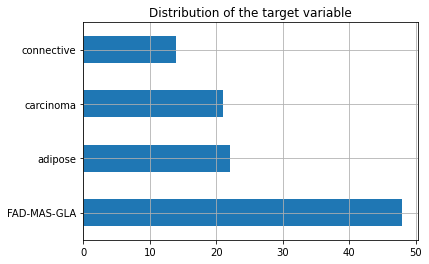

In [9]:
import matplotlib.pyplot as plt
plt.title("Distribution of the target variable")

df.Class.apply(lambda x: "FAD-MAS-GLA" if x in ["fibro-adenoma", "mastopathy", "glandular"] else x).value_counts().plot.barh()
plt.grid()
plt.savefig("distribution.svg")

In [10]:
couples = dict(zip(df.Class.value_counts().index, range(6)))
couples

{'adipose': 0,
 'carcinoma': 1,
 'mastopathy': 2,
 'fibro-adenoma': 3,
 'glandular': 4,
 'connective': 5}

to be merged: fibro-adenoma, mastopathy and glandular 

In [11]:
couples["glandular"] = couples["mastopathy"]
couples["fibro-adenoma"] = couples["mastopathy"]
couples["connective"] = 3

In [12]:
CatClass = df.Class

In [13]:
df.Class = df.Class.apply(lambda x: couples[x])

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score

# vectorization
scl = StandardScaler()
y = df.Class.values
X = df.iloc[:, 1:]
X = scl.fit_transform(X)

# Visualization tools

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import seaborn as sns
from matplotlib.patches import Ellipse

ColorSet1 = cm.Set1.colors

diseas = couples.keys()

diseasColors = {
    "adipose": ColorSet1[1], 
    "carcinoma": ColorSet1[2],
    "fibro-adenoma, mastopathy and glandular": ColorSet1[3], 
    "connective": ColorSet1[4]
}

dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]

unwound_diseasColors = {
 'adipose': ColorSet1[1],
 'carcinoma': ColorSet1[2],
 'fibro-adenoma': ColorSet1[3],
 'mastopathy': ColorSet1[3],
 'glandular': ColorSet1[3],
 'connective': ColorSet1[4]
}

CatClass.Color = CatClass.apply(lambda x: unwound_diseasColors[x])
CatClass = pd.concat((CatClass.Color, CatClass), axis = 1)
CatClass.columns = ["Color", "Class"]

# KNN Classifier

Note: Throughout all this notebook the number of neighbors will be set to 3. 

In [16]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 3)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify = y, test_size = 0.40, random_state = rs)
clf.fit(Xtrain, ytrain)

y_pred = clf.predict(Xtest)

cmatrix = confusion_matrix(ytest, y_pred)
KNN_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(ytest, y_pred, average = None))
                 )

print(classification_report(ytest, y_pred, target_names = np.array(list(diseasColors.keys()))))
KNN_mr = recall_score(ytest, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      1.00      1.00         9
                              carcinoma       1.00      0.88      0.93         8
fibro-adenoma, mastopathy and glandular       0.90      1.00      0.95        19
                             connective       1.00      0.83      0.91         6

                               accuracy                           0.95        42
                              macro avg       0.98      0.93      0.95        42
                           weighted avg       0.96      0.95      0.95        42



<ipython-input-17-322690ac565a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


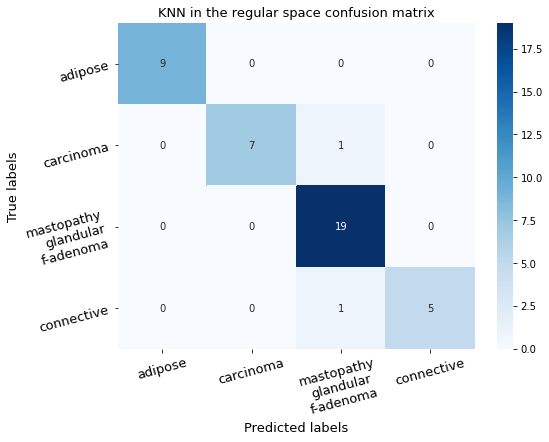

In [17]:
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap = "Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontdict = {"fontsize": 13})
ax.set_ylabel('True labels', fontdict = {"fontsize": 13}) 
ax.set_title('KNN in the regular space confusion matrix', fontdict = {"fontsize": 13}) 

ax.set_xticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15)
ax.set_yticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15)
fig.show()
fig.savefig("knn_reg_cm.svg")

# LDA

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Classification with LDA

### Classification Report

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify = y, test_size = 0.40, random_state = rs)
lda = LinearDiscriminantAnalysis()

lda.fit(Xtrain, ytrain)
y_pred = lda.predict(Xtest)

cmatrix = confusion_matrix(ytest, y_pred)
LDA_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(ytest, y_pred, average = None))
                 )
print(classification_report(ytest, y_pred, target_names = np.array(list(diseasColors.keys()))))
LDA_mr = recall_score(ytest, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      0.89      0.94         9
                              carcinoma       1.00      0.88      0.93         8
fibro-adenoma, mastopathy and glandular       0.90      1.00      0.95        19
                             connective       0.83      0.83      0.83         6

                               accuracy                           0.93        42
                              macro avg       0.93      0.90      0.91        42
                           weighted avg       0.93      0.93      0.93        42



### Heatmap

<ipython-input-20-2c368b8ceefd>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


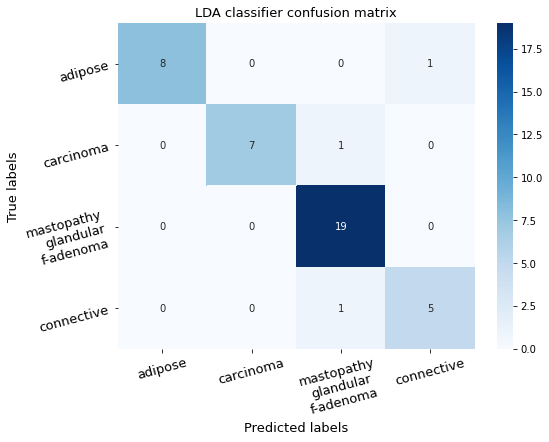

In [20]:
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap = "Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontdict = {"fontsize": 13})
ax.set_ylabel('True labels', fontdict = {"fontsize": 13}) 
ax.set_title('LDA classifier confusion matrix', fontdict = {"fontsize": 13}) 
ax.set_xticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15)
ax.set_yticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15)
fig.show()

## Visualization

In [21]:
lda_tot = LinearDiscriminantAnalysis()
Xlda = lda_tot.fit_transform(X, y)

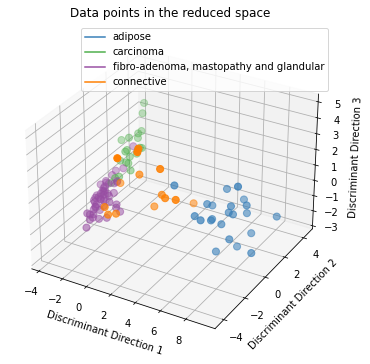

In [22]:
dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]
sg_3d = plt.figure(figsize=(6, 6))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Xlda[:, 0], Xlda[:, 1], Xlda[:, 2], s = 50,
                 c = CatClass.Color)
plt.title('Data points in the reduced space')

ax_sg_3d.set_xlabel("Discriminant Direction 1")
ax_sg_3d.set_ylabel("Discriminant Direction 2")
ax_sg_3d.set_zlabel("Discriminant Direction 3")

plt.legend(dLegend, [k for k in diseasColors.keys()])
plt.grid()
plt.show()

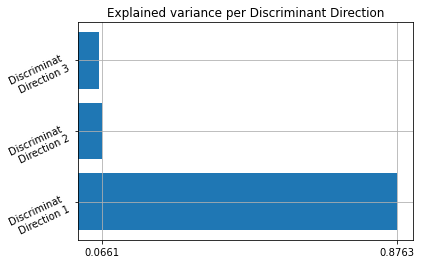

In [75]:
plt.title("Explained variance per Discriminant Direction")
plt.barh(np.arange(3), lda.explained_variance_ratio_)
plt.yticks(ticks = np.arange(3), labels = [f"Discriminat \n Direction {j+1}" for j in range(3)], rotation = 25)

variances = sorted(lda.explained_variance_ratio_)

plt.xticks(ticks = variances[1:], labels = ['{:.4f}'.format(x) for x in variances[1:]])
plt.grid()

plt.savefig("explainedLDA.svg")
plt.show()

Considering the above presented explained variance ratio it is possible to obtain almost 94% of the the total variance with only 2 components. Hence, to ease the visualization, we have decided to use this fact.

In [24]:
lda_2 = LinearDiscriminantAnalysis(n_components = 2)
Xlda2 = lda_tot.fit_transform(X, y)

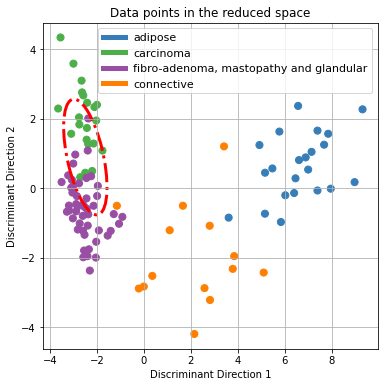

In [76]:
dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]
sg = plt.figure(figsize=(6, 6))
ax_ = sg.add_subplot()
ax_.scatter(Xlda2[:, 0], Xlda2[:, 1], s = 50,
                 c = CatClass.Color)

plt.title('Data points in the reduced space')

ax_.set_xlabel("Discriminant Direction 1")
ax_.set_ylabel("Discriminant Direction 2")

ell = Ellipse(xy = (-2.5,0.9), width = 3.5, height = 1.5, angle = -70, color='r',
             fill = False, linestyle = "-.", linewidth = 3)
ax_.add_patch(ell)

leg = ax_.legend(dLegend, [k for k in diseasColors.keys()], prop = {"size": 11})

for line in leg.get_lines():
    line.set_linewidth(5.0)
    
plt.grid()
plt.savefig("LDA2_space.svg")
plt.show()

## Classification with KNN 

### Classification Report 

In [26]:
clf = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xlda, y, stratify = y, test_size = 0.40, random_state = rs)
clf.fit(Xtrain, ytrain)

y_pred = clf.predict(Xtest)

LDA_knn_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(ytest, y_pred, average = None))
                 )

cmatrix = confusion_matrix(ytest, y_pred)
print(classification_report(ytest, y_pred, target_names = np.array(list(diseasColors.keys()))))
LDA_knn_mr = recall_score(ytest, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      0.89      0.94         9
                              carcinoma       1.00      1.00      1.00         8
fibro-adenoma, mastopathy and glandular       1.00      1.00      1.00        19
                             connective       0.86      1.00      0.92         6

                               accuracy                           0.98        42
                              macro avg       0.96      0.97      0.97        42
                           weighted avg       0.98      0.98      0.98        42



### Heatmap

<ipython-input-77-05461a0c151a>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


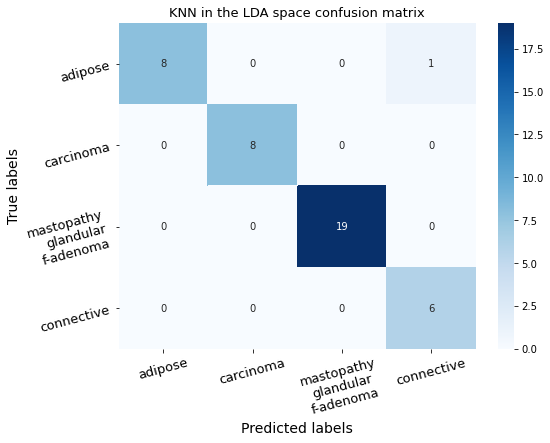

In [77]:
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap = "Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 14); ax.set_ylabel('True labels', fontsize = 14); 

ax.set_title('KNN in the LDA space confusion matrix', fontsize = 13); 
ax.set_xticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15);
ax.set_yticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15);

fig.savefig("knnLDA_cm.svg")
fig.show()

# PCA

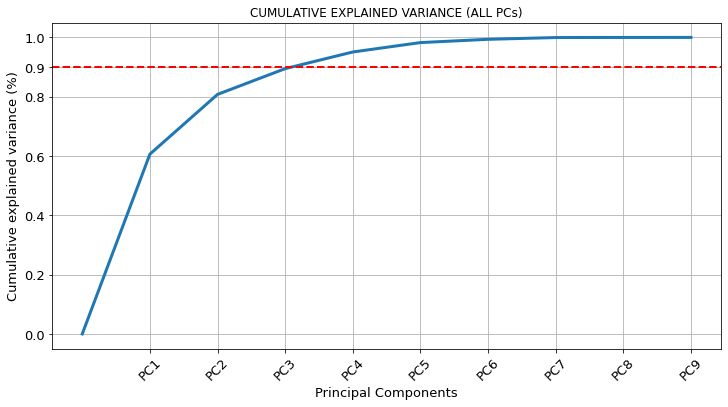

In [28]:
from sklearn.decomposition import PCA
pca = PCA()

#fitting pca on the data
pca.fit(X)

#selecting the number of components
plt.figure(figsize=(12, 6))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0), linewidth = 3)
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')

plt.xticks(ticks=np.arange(1, pca.n_features_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca.n_features_ + 1)],
           rotation=45, fontsize = 13)
plt.yticks(ticks = [0, 0.20, 0.40, 0.60, 0.80, 0.90, 1.0], fontsize = 13)
plt.axhline(y = 0.9, color = "red", linestyle = "--", linewidth = 2)
plt.xlabel('Principal Components', fontsize = 13)
plt.ylabel('Cumulative explained variance (%)', fontsize = 13)
plt.grid()
plt.savefig("cum_var_pca.svg")
plt.show()

Considering this visualization we resort to chose as number of principal components *3*. 

In [29]:
m = 3
pca = PCA(n_components = m)
pca.fit(X);

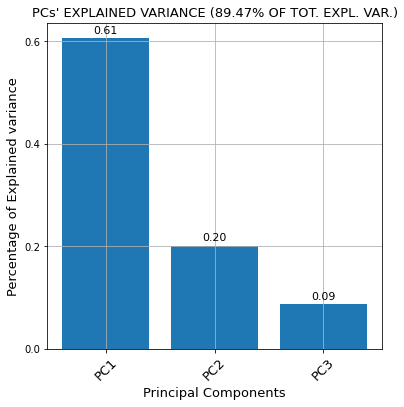

In [30]:
# COMPUTE THE PERCENTAGE OF TOT. EXPL. VARIANCE (ROUNDED TO 2 DECIMALS)
round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum() * 100, decimals=2)

# MAKE THE BARPLOT
fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(range(1, m + 1), pca.explained_variance_ratio_)

ax.set_title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)", fontsize = 13)
ax.set_yticks(ticks = np.arange(0, 0.8, 0.2))
ax.set_xticks(ticks=np.arange(1, m + 1))

ax.set_xticklabels(labels=[f'PC{i}' for i in range(1, m + 1)],
           rotation=45, fontdict = {"fontsize": 13})

for bar in ax.patches:
    
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=11, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel('Principal Components', fontsize = 13)
plt.ylabel('Percentage of Explained variance', fontsize = 13)
plt.grid()
plt.savefig("expl_var_pca.svg")
plt.show()

Considering the specifity of each feature interpretation is not completely possible. 

In [31]:
Xpca = pca.transform(X)

## Visualization

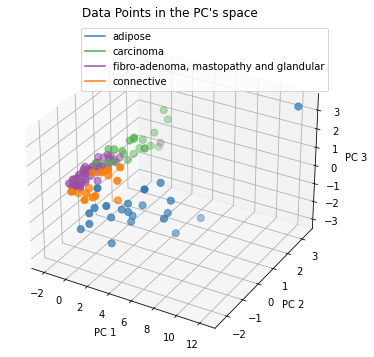

In [32]:
dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]
sg_3d = plt.figure(figsize=(6, 6))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], s = 50,
                 c = CatClass.Color)

plt.title("Data Points in the PC's space")

ax_sg_3d.set_xlabel("PC 1")
ax_sg_3d.set_ylabel("PC 2")
ax_sg_3d.set_zlabel("PC 3")

plt.legend(dLegend, [k for k in diseasColors.keys()])
plt.grid()
plt.savefig("PCA_3dspace.svg")
plt.show()

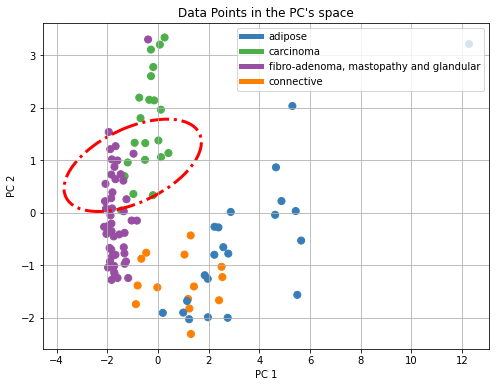

In [33]:
#visualization in 2d
pca_2 = PCA(n_components = 2)
pca_2.fit(X);

Xpca2 = pca_2.fit_transform(X)

dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(Xpca2[:,0], Xpca2[:,1], s = 50, c = CatClass.Color)

ax.set_title("Data Points in the PC's space")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ell = Ellipse(xy = (-1.0,0.9), width = 5.5, height = 1.5, angle = 190, color='r',
             fill = False, linestyle = "-.", linewidth = 3)
ax.add_patch(ell)

leg = ax.legend(dLegend, [k for k in diseasColors.keys()], prop = {"size": 10})
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.grid()
fig.savefig("PCA2dspace.svg")
plt.show()

Poor performace of the KNN in the PC space is mainly due to the construction itself of the PCA. 
This method is projecting the points in a space in which the variance is maximized, but no assumption can be made on the separability of the points. Counterwise, the LDA projects the points in a subspace that is created with the goal of obtaining linear separability. 

## Classification with KNN

In [34]:
clf = KNeighborsClassifier(n_neighbors = 3)

X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.40, random_state = rs, stratify = y)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)

PCA_knn_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(y_test, y_pred, average = None))
                 )

print(classification_report(y_test, y_pred, target_names = np.array(list(diseasColors.keys()))))
PCA_knn_mr = recall_score(y_test, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      0.89      0.94         9
                              carcinoma       1.00      0.88      0.93         8
fibro-adenoma, mastopathy and glandular       0.90      1.00      0.95        19
                             connective       0.83      0.83      0.83         6

                               accuracy                           0.93        42
                              macro avg       0.93      0.90      0.91        42
                           weighted avg       0.93      0.93      0.93        42



In [35]:
print(pd.DataFrame(PCA_knn_recall.values(), index = PCA_knn_recall.keys(), columns = ["Recall Score"]).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Recall Score \\
\midrule
adipose                                 &      0.888889 \\
carcinoma                               &      0.875000 \\
fibro-adenoma, mastopathy and glandular &      1.000000 \\
connective                              &      0.833333 \\
\bottomrule
\end{tabular}



<ipython-input-36-24ae77f0776e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


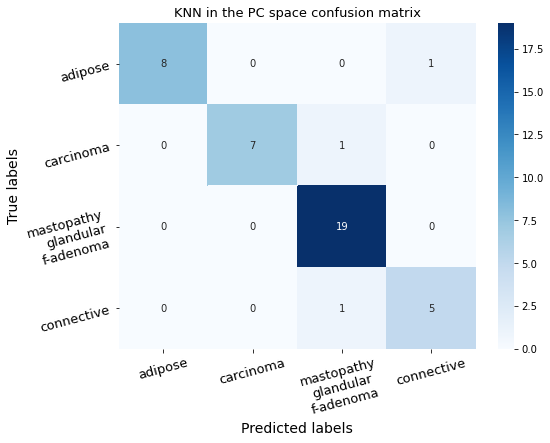

In [36]:
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap = "Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 14); ax.set_ylabel('True labels', fontsize = 14); 

ax.set_title('KNN in the PC space confusion matrix', fontsize = 13); 
ax.set_xticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15);
ax.set_yticklabels(labels = ["adipose", "carcinoma", "mastopathy\nglandular\nf-adenoma", "connective"],
                  fontdict = {"fontsize": 13}, rotation = 15);
fig.savefig("knn_PC_space.svg")
fig.show()

# LDA (implemented) 

In [37]:
#importing our implementation of the LDA
from src.LDA_cla import LDA
s = LDA()

## Classification with LDA

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.40, random_state = rs)
s.fit(X_train, y_train)

y_pred = s.predict(X_test)

cmatrix = confusion_matrix(ytest, y_pred)
LDA_s_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(y_test, y_pred, average = None))
                 )
print(classification_report(ytest, y_pred, target_names = np.array(list(diseasColors.keys()))))
LDA_s_mr = recall_score(y_test, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      0.89      0.94         9
                              carcinoma       1.00      0.88      0.93         8
fibro-adenoma, mastopathy and glandular       0.95      1.00      0.97        19
                             connective       0.86      1.00      0.92         6

                               accuracy                           0.95        42
                              macro avg       0.95      0.94      0.94        42
                           weighted avg       0.96      0.95      0.95        42



## Classification with KNN

In [39]:
sTot = LDA()
sTot.fit(X,y)
X_tr = sTot.transform(X)

In [40]:
clf = KNeighborsClassifier(n_neighbors = 3)

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, stratify = y, test_size = 0.40, random_state = rs)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
LDA_s_knn_recall = dict(zip(np.array(list(diseasColors.keys())),
                      recall_score(y_test, y_pred, average = None))
                 )
print(classification_report(y_test, y_pred, target_names = np.array(list(diseasColors.keys()))))
LDA_s_knn_mr = recall_score(y_test, y_pred, average = "micro")

                                         precision    recall  f1-score   support

                                adipose       1.00      0.89      0.94         9
                              carcinoma       1.00      1.00      1.00         8
fibro-adenoma, mastopathy and glandular       1.00      1.00      1.00        19
                             connective       0.86      1.00      0.92         6

                               accuracy                           0.98        42
                              macro avg       0.96      0.97      0.97        42
                           weighted avg       0.98      0.98      0.98        42



## Visualization

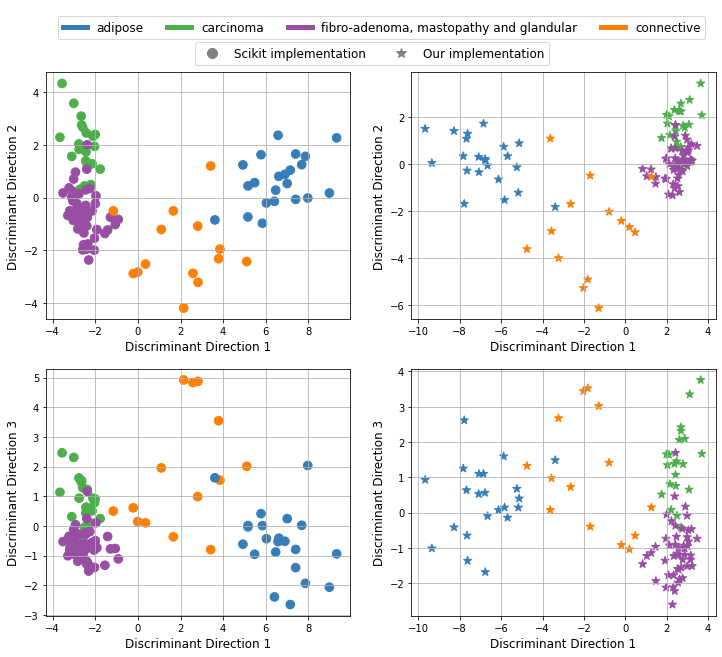

In [78]:
import matplotlib.lines as mlines

dLegend = [Line2D([0], [0], color=diseasColors[k]) for k in diseasColors.keys()]

fig, ax_ = plt.subplots(nrows = 2, ncols = 2, figsize = (12,10))

ax_[0,1].scatter(X_tr[:, 0], X_tr[:, 1], s = 75,
                 c = CatClass.Color, marker = "*")

ax_[0,0].scatter(Xlda[:, 0], Xlda[:, 1], s = 75,
                 c = CatClass.Color, marker = "o")

ax_[0,0].set_xlabel("Discriminant Direction 1", fontdict = {"fontsize": 12})
ax_[0,0].set_ylabel("Discriminant Direction 2", fontdict = {"fontsize": 12})

ax_[0,1].set_xlabel("Discriminant Direction 1", fontdict = {"fontsize": 12})
ax_[0,1].set_ylabel("Discriminant Direction 2", fontdict = {"fontsize": 12})

ax_[1,1].scatter(X_tr[:, 0], X_tr[:, 2], s = 75,
                 c = CatClass.Color, marker = "*")

ax_[1,0].scatter(Xlda[:, 0], Xlda[:, 2], s = 75,
                 c = CatClass.Color, marker = "o")

ax_[1,0].set_xlabel("Discriminant Direction 1", fontdict = {"fontsize": 12})
ax_[1,0].set_ylabel("Discriminant Direction 3", fontdict = {"fontsize": 12})

ax_[1,1].set_xlabel("Discriminant Direction 1", fontdict = {"fontsize": 12})
ax_[1,1].set_ylabel("Discriminant Direction 3", fontdict = {"fontsize": 12})


blue_star = mlines.Line2D([], [], color='grey', marker='*', linestyle = "None",
                          markersize=10, label="Our implementation")

red_square = mlines.Line2D([], [], color='grey', marker='o', linestyle = "None",
                          markersize=10, label='Scikit implementation')

fig.legend(handles=[red_square, blue_star], ncol = 2, loc = (0.27,0.90), prop = {"size": 12})

ax_[0,0].grid()
ax_[0,1].grid()
ax_[1,0].grid()
ax_[1,1].grid()

leg = fig.legend(dLegend, [k for k in diseasColors.keys()], ncol = 4, loc = (0.08,0.94), prop = {"size": 12})

for line in leg.get_lines():
    line.set_linewidth(5.0)

fig.legend
fig.savefig("comparison.svg")
plt.show()

# Conclusions

In [42]:
KNN_values = np.array(list(KNN_recall.values())).reshape(-1,1)
LDA_values = np.array(list(LDA_recall.values())).reshape(-1,1)
LDA_knn_values = np.array(list(LDA_knn_recall.values())).reshape(-1,1)
PCA_knn_values = np.array(list(PCA_knn_recall.values())).reshape(-1,1)
LDA_s_values = np.array(list(LDA_s_recall.values())).reshape(-1,1)
LDA_s_knn_values = np.array(list(LDA_s_knn_recall.values())).reshape(-1,1)

In [43]:
recall_scores = np.hstack((KNN_values, PCA_knn_values, LDA_values,
                           LDA_knn_values, LDA_s_values, LDA_s_knn_values)
                         )

In [44]:
res = pd.DataFrame(columns = ["Regular KNN", "KNN in the PCA space","LDA classifier",
                              "KNN in the LDA space", "our LDA classifier", "KNN in our LDA space"], 
                   index = KNN_recall.keys(), data = recall_scores)

In [45]:
res

,Regular KNN,KNN in the PCA space,LDA classifier,KNN in the LDA space,our LDA classifier,KNN in our LDA space
adipose,1.000000,0.888889,0.888889,0.888889,0.888889,0.888889
carcinoma,0.875000,0.875000,0.875000,1.000000,0.875000,1.000000
"fibro-adenoma, mastopathy and glandular",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
connective,0.833333,0.833333,0.833333,1.000000,1.000000,1.000000


In [46]:
mr = (KNN_mr, PCA_knn_mr, LDA_mr, LDA_knn_mr, LDA_s_mr, LDA_s_knn_mr)

In [47]:
car = (
    KNN_recall["carcinoma"],
    PCA_knn_recall["carcinoma"],
    LDA_recall["carcinoma"],
    LDA_knn_recall["carcinoma"],
    LDA_s_recall["carcinoma"],
    LDA_s_knn_recall["carcinoma"]
)

In [48]:
w_recall = pd.DataFrame(index = res.columns, columns = ["Weighted Recall", "Carcinoma Recall"], 
                        data = list(zip(mr, car)))

In [79]:
print(w_recall.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Weighted Recall &  Carcinoma Recall \\
\midrule
Regular KNN          &         0.952381 &             0.875 \\
KNN in the PCA space &         0.928571 &             0.875 \\
LDA classifier       &         0.928571 &             0.875 \\
KNN in the LDA space &         0.976190 &             1.000 \\
our LDA classifier   &         0.952381 &             0.875 \\
KNN in our LDA space &         0.976190 &             1.000 \\
\bottomrule
\end{tabular}



We are confident in using this recall to compare the different methods exactly because we used a 40% portion of data as holdout. This implied that the single metrics have been computed with more precision with respect to the total of the observations, and also allowed us to see how the LDA technique really improves the quality of the predictions, especially when paired with an algorithm such as KNN. 